In [1]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random, re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc
from sklearn import datasets
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
def normalize(data):return (data-np.min(data)) / (np.max(data)-np.min(data))
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
def get_ci(samples, confidence=0.95): return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)


In [99]:
out_dir = "link/wv_3d_blob"

## aligns

In [101]:
df = utils.get_wandb_runs("wv_3d_blob_aligns")
eval_cols = ['NINO_ds_acc',  'NIFO_ds_acc', 'NI_h2h', 'NO_h2h', 'test_triplet_acc','test_clf_acc', 'test_1nn_acc', 'rNINO_ds_acc',]
config_cols = ["seed", "weights", "filtered", "embed_dim", "lamda", "wandb_group", "wandb_project"]
df = utils.strip_df(df, eval_cols, config_cols)
df["align"] = [utils.find_float(x)[0] for x in df["wandb_group"]]

In [103]:
df_50 = df[df["embed_dim"]==50]
df_512 = df[df["embed_dim"]==512]

In [104]:
df_50[df_50["name"]=="MTL0.5"].groupby("align").mean()

,seed,filtered,embed_dim,lamda,NINO_ds_acc,NIFO_ds_acc,NI_h2h,NO_h2h,test_triplet_acc,test_clf_acc,test_1nn_acc,rNINO_ds_acc
align,,,,,,,,,,,,
0.850,1.0,1.0,50.0,0.5,0.882500,0.997500,0.891111,0.866528,0.982674,0.997500,1.000000,0.881667
0.960,1.0,1.0,50.0,0.5,0.915833,0.999167,0.894028,0.860556,0.981897,0.999167,1.000000,0.915833
0.985,1.0,1.0,50.0,0.5,0.985833,1.000000,0.782500,0.990139,0.980488,1.000000,1.000000,0.985833
0.990,1.0,1.0,50.0,0.5,0.989167,1.000000,0.746944,0.974167,0.981289,1.000000,1.000000,0.989167
1.000,1.0,1.0,50.0,0.5,0.997500,1.000000,0.871944,0.930972,0.976043,1.000000,0.999167,0.998333


In [105]:
df_512[df_512["name"]=="MTL0.5"].groupby("align").mean()

,seed,filtered,embed_dim,lamda,NINO_ds_acc,NIFO_ds_acc,NI_h2h,NO_h2h,test_triplet_acc,test_clf_acc,test_1nn_acc,rNINO_ds_acc
align,,,,,,,,,,,,
0.850,1.0,1.0,512.0,0.5,0.910833,0.999167,0.885139,0.818194,0.978965,0.999167,0.999167,0.910833
0.960,1.0,1.0,512.0,0.5,0.920000,1.000000,0.887917,0.771944,0.976854,1.000000,1.000000,0.920000
0.985,1.0,1.0,512.0,0.5,0.985000,0.995833,0.818611,0.974028,0.979873,0.995833,1.000000,0.985000
0.990,1.0,1.0,512.0,0.5,0.989167,0.999167,0.793333,0.978750,0.981177,0.999167,0.998333,0.990000
1.000,1.0,1.0,512.0,0.5,0.997500,0.996667,0.888194,0.920833,0.974873,0.996667,0.999167,0.996667


In [87]:
filtered_df = df[df["filtered"]==True]
unfiltered_df = df[df["filtered"]==False]

In [100]:
df.to_csv(out_dir + "/wv_3d_blob_filtered.csv")

<AxesSubplot:xlabel='align', ylabel='NI_h2h'>

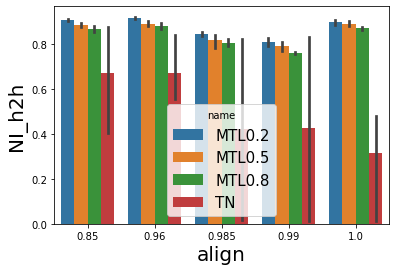

In [93]:
sns.barplot(data=filtered_df, x="align",y="NI_h2h",hue="name")

In [64]:
unfiltered_df.to_csv(out_dir + "/wv_3d_square_unfiltered.csv",index=False)
filtered_df.to_csv(out_dir + "/wv_3d_square_filtered.csv",index=False)

## noisy

In [83]:
df = utils.get_wandb_runs("wv_3d_square_noisy")
eval_cols = ['NINO_ds_acc',  'NIFO_ds_acc', 'NI_h2h', 'NO_h2h', 'test_triplet_acc','test_clf_acc', 'test_1nn_acc', 'rNINO_ds_acc',]
config_cols = ["seed", "weights", "filtered", "embed_dim", "lamda", "wandb_group", "wandb_project"]
df = utils.strip_df(df, eval_cols, config_cols)
df["align"] = [utils.find_float(x)[0] for x in df["wandb_group"]]
df["noise"] = [utils.find_float(x)[1] for x in df["wandb_group"]]

In [84]:
df["filtered"] = [True if f=="None" else f for f in df["filtered"]]
filtered_df = df[df["filtered"]==True]
unfiltered_df = df[df["filtered"]==False]
filtered_df.to_csv(out_dir + "/wv_3d_square_noisy_0.925_filtered.csv")
unfiltered_df.to_csv(out_dir + "/wv_3d_square_noisy_0.925_unfiltered.csv")

In [171]:
df[df["align"]==0.925].to_csv(out_dir + "/wv_3d_square_noisy_0.925.csv")
df[df["align"]==0.62].to_csv(out_dir + "/wv_3d_square_noisy_0.62.csv")

## RESN

In [94]:
df = pd.read_csv("evals/RESN_evals.csv")
df["align"] = [utils.find_float(x)[0] for x in df["group"]]
df = df.rename({"group":"wandb_group"},axis=1)
df["name"] = ["RESN"]*len(df)

In [95]:
for col in config_cols+eval_cols:
    if col not in df.columns: df[col] = [None]*len(df)

In [96]:
df.to_csv(out_dir + "/RESN.csv")

## scratch

In [122]:
df[df["align"]==1].groupby(["name"]).mean()

,seed,filtered,embed_dim,lamda,align,NINO_ds_acc,NIFO_ds_acc,NI_h2h,NO_h2h,test_triplet_acc,test_clf_acc,test_1nn_acc,rNINO_ds_acc
name,,,,,,,,,,,,,
MTL0.2,1.0,1.0,512.0,0.2,1.0,0.986600,0.986600,0.862786,0.911083,0.972380,0.986600,0.989112,0.986600
MTL0.5,1.0,1.0,512.0,0.5,1.0,0.989950,0.979899,0.864740,0.898241,0.975604,0.979899,0.987437,0.985762
MTL0.8,1.0,1.0,512.0,0.8,1.0,0.989950,0.988275,0.849386,0.922390,0.974276,0.988275,0.989950,0.990787
TN,1.0,1.0,512.0,0.0,1.0,0.989112,0.991625,0.883305,0.945422,0.971179,0.556114,0.991625,0.989112


In [134]:
df[df["align"]==1][["name"]+eval_cols].groupby(["name"]).agg(get_ci)

,NINO_ds_acc,NIFO_ds_acc,NI_h2h,NO_h2h,test_triplet_acc,test_clf_acc,test_1nn_acc,rNINO_ds_acc
name,,,,,,,,
MTL0.2,0.007207,0.025986,0.062288,0.080156,0.030150,0.025986,0.028828,0.031415
MTL0.5,0.000000,0.033027,0.067449,0.177430,0.016216,0.033027,0.024966,0.031415
MTL0.8,0.000000,0.014414,0.073302,0.111309,0.010419,0.014414,0.012483,0.007207
TN,0.031415,0.007207,0.042706,0.048093,0.025330,0.226881,0.007207,0.031415


In [133]:
df[(df["align"]==1) & (df["name"]=="MTL0.5")]

,name,model,seed,weights,filtered,embed_dim,lamda,align,wandb_project,NINO_ds_acc,NIFO_ds_acc,NI_h2h,NO_h2h,test_triplet_acc,test_clf_acc,test_1nn_acc,rNINO_ds_acc
1,MTL0.5,MTL,2,"[1, 1, 0, 0]",True,512,0.5,1.0,wv_3d_linear,0.98995,0.972362,0.850084,0.860972,0.976678,0.972362,0.987437,0.979900
9,MTL0.5,MTL,1,"[1, 1, 0, 0]",True,512,0.5,1.0,wv_3d_linear,0.98995,0.984925,0.867253,0.901591,0.971938,0.984925,0.992462,0.984925
22,MTL0.5,MTL,0,"[1, 1, 0, 0]",True,512,0.5,1.0,wv_3d_linear,0.98995,0.982412,0.876884,0.932161,0.978195,0.982412,0.982412,0.992462


In [43]:
cis = []
for align in ["0.5","0.8","0.83","0.92","0.925","1"]:
    data = df[df["group"]==f"align={align}"]["NIFO_ds_acc_k=1"]
    cis.append(np.around(get_ci(data),3))

In [112]:
df = pd.read_csv("link/wv_3d_square/wv_3d_square_num_512.csv")
MTL = df[df["wandb_name"]=="MTL0.5"]

In [113]:
# unfiltered_MTL = TN[["filtered" not in x for x in TN["wandb_group"]]]
MTL = MTL[["0.925" in x for x in MTL["wandb_group"]]]

In [118]:
cis = []
for align in [0.5,0.25,0.125,0.0625,0.03125,0.015625,0.0078125]:
    data = MTL[MTL["wandb_group"]==f"align=0.925_p={align}"]["h2h_512"]
    cis.append(np.around(get_ci(data)/2,3))

In [119]:
cis

[0.006, 0.02, 0.043, 0.016, 0.034, 0.006, 0.045]